<a href="https://colab.research.google.com/github/CubatLin/AmpliGraph/blob/master/tutorial/colab/(Origin)_ECAI_2020_KGE_Tutorial_Hands_on_Session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Knowledge Graph Embeddings: From Theory to Practice**
### ECAI 2020 Tutorials, September 4th 2020, Friday, 13:45-17:00 CEST
###(Hands-on Session)

<u>**Contents**</u>
- Loading a KG and creating train/test splits
- Training and evaluating a KGE Model
- Testing user hypothesis
- Early stopping and types of evaluation
- Choosing model hyperparameters
- Discovering facts using trained model
- Visualizing embeddings and Clustering


# 1. Introduction and Preliminaries

For this hands-on tutorial, we will be using the open-source library [AmpliGraph](https://github.com/Accenture/AmpliGraph).

Let's start by installing the library and it's dependencies, and then importing the libraries used in this tutorial. 

In [1]:
# If running on local system execute this cell

# Install CUDA
#! conda install -y cudatoolkit=10.0

# Install cudnn libraries
# This library improves the performance of tensorflow, however, we need to give up determinism over speed.
#! conda install cudnn=7.6

# Install tensorflow GPU 
#! pip install tensorflow-gpu==1.15.3

In [2]:
# If using Google Colab run this cell 

# select tensorflow version for colab 
%tensorflow_version 1.x

TensorFlow 1.x selected.


Let us check if tensorflow is correctly installed and if we can access the GPU

In [3]:
import tensorflow as tf 

print('TensorFlow  version: {}'.format(tf.__version__))

# Get the GPU name
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow  version: 1.15.2
Found GPU at: /device:GPU:0


Let's install AmpliGraph and other dependencies

In [4]:
%%capture 
# Install AmpliGraph library
! pip install ampligraph

# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

In [5]:
# All imports used in this tutorial 
%tensorflow_version 1.x
import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 1.4.0


---
# 2. Loading a Knowledge Graph dataset

To begin with we're going to need a knowledge graph, so let's load a standard knowledge graph called ***Freebase-15k-237***. 

Ampligraph provides a set of APIs to [load standard knowledge graphs](https://docs.ampligraph.org/en/1.3.1/ampligraph.datasets.html#benchmark-datasets-loaders). 

Also provided are a set of APIs load csv, ntriples and rdf formats. Details can be found [here](https://docs.ampligraph.org/en/1.3.1/ampligraph.datasets.html#loaders-for-custom-knowledge-graphs)


In [6]:
from ampligraph.datasets import load_fb15k_237, load_wn18rr, load_yago3_10


For this tutorial we have remapped the IDs of freebase 237 and created a csv file containing human readable names instead of IDs. 

In [7]:
import pandas as pd

URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header=None)
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark
3,the departed,/award/award_winning_work/awards_won./award/aw...,leonardo dicaprio
4,marilyn manson,/people/person/profession,actor


In [8]:
print('Total triples in the KG:', dataset.shape)

Total triples in the KG: (310079, 3)



![KG](https://user-images.githubusercontent.com/39597669/90747195-9fc44c80-e2c8-11ea-9f70-097993581bac.png) 



## 2.1 Create training, validation and test splits

Let's use the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/1.3.1/generated/ampligraph.evaluation.train_test_split_no_unseen.html?#train-test-split-no-unseen) function provided by Ampligraph to create the training, validation and test splits. 

This API ensures that the test and validation splits contains triples whose entities are "seen" during training. 


In [9]:
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

print('Total triples:', dataset.shape)
print('Size of train:', X_train.shape)
print('Size of valid:', X_valid.shape)
print('Size of test:', X_test.shape)

Total triples: (310079, 3)
Size of train: (308579, 3)
Size of valid: (500, 3)
Size of test: (1000, 3)


##**Key Takeaways**

- `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training

---
# 3. Model Training
Now that we have split the dataset, let's dive directly into model training. 

Let us create a TransE model and train it on the training split using the `fit` function.

**TransE** is one of the first embedding models which set the platform for the KGE research. It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models. 

<center>$f = - || s + p - o ||_{n}$</center>


In [10]:
from ampligraph.latent_features import TransE

model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)

model.fit(X_train)

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE-small.pkl')

Average TransE Loss:   0.013551: 100%|██████████| 100/100 [00:12<00:00,  7.86epoch/s]


You can refer [this link](https://docs.ampligraph.org/en/latest/api.html) for detailed explaination of the parameters and their values.

## 3.1 Compute the evaluation metrics

### Per triple metrics:
This is a metric that is computed for each test set triple:

- **score**: This is the value assigned to a triple, by the model, by applying the scoring function.

Let's look at how we can get the score for a triple of interest and how to interpret it.


In [11]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score:
 [-8.411186]


But what does this score tell you? Nothing! It is just a value. In order to interpret the score we have 2 options:

1. We can create a list of hypothesis that we want to test, score them and then choose the top n hypothesis as True statements.

2. As described earlier in the theory section, unlike classification task, we are doing a learning to rank task. In order to interpret the score we can generate the corruptions and compare the triple score against the scores of corruptions to see how well does the model rank the test triple against them.


Let's look at the first option. Let us create a list of hypothesis and score them.

In [12]:
import numpy as np
list_of_actors = ['salma hayek', 'carrie fisher', 'natalie portman',  'kristen bell',
                  'mark hamill', 'neil patrick harris', 'harrison ford' ]

# stack it horizontally to create s, p, o
hypothesis = np.column_stack([list_of_actors, 
                              ['/film/actor/film./film/performance/film'] * len(list_of_actors),
                              ['star wars'] * len(list_of_actors),
                             ])

# score the hypothesis
triple_scores = model.predict(hypothesis)

# append the scores column
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sort by score in descending order
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['harrison ford', '/film/actor/film./film/performance/film',
        'star wars', '-8.411186'],
       ['natalie portman', '/film/actor/film./film/performance/film',
        'star wars', '-8.487747'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars', '-8.995587'],
       ['neil patrick harris', '/film/actor/film./film/performance/film',
        'star wars', '-9.21589'],
       ['salma hayek', '/film/actor/film./film/performance/film',
        'star wars', '-9.554007'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars', '-9.60973'],
       ['mark hamill', '/film/actor/film./film/performance/film',
        'star wars', '-9.63883']], dtype='<U39')


- **rank**: For a triple, this metric is computed by generating corruptions and then scoring them and computing the rank(position) of the triple score against the corruptions. The pseudocode and the example illustrates how to compute rank on the test set.

         for each test set triple <s, p, o>:
                 a. Compute the score of the test triple (hypothesis) 
                     hypothesis_score = score(<s, p, o>)
                     
                 b. Generate the subject corruptions 
                         sub_corr = <?, p, o>
                 c. Compute the score of the subject corruptions
                         sub_corr_score = score(sub_corr) 
                 d. Find the position of hypothesis_score in sub_corr_score to get the sub_rank
                   
                 e. Generate the object corruption 
                         obj_corr = <s, p, ?>
                 f. Compute the score of the object corruptions
                         obj_corr_score = score(obj_corr) 
                 g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
                 
                 h. Return rank = [sub_rank, obj_rank]



![rank example](https://user-images.githubusercontent.com/281477/90627614-14897f00-e214-11ea-8f8e-d57da9888606.png)





### Illustrative Example 

**Compute the score of the test triple**

In [13]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score:
 [-8.411186]


Before generating the corruptions, let us look at the number of unique entities present in our dataset

In [14]:
print('The number of unique entities:', len(model.ent_to_idx))

The number of unique entities: 14184


**Generate the subject *corruptions* and compute rank**
> ```sub_corr = <?, p, o>```

In [15]:

subj_corr =  np.column_stack([list(model.ent_to_idx.keys()),
                [test_triple[1]] * len(model.ent_to_idx), 
                [test_triple[2]] * len(model.ent_to_idx)])

print('Subject corruptions:\n', subj_corr)
print('\nSize of subject corruptions:\n', subj_corr.shape)

Subject corruptions:
 [['/m/011xg5' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yd2' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yxg' '/film/actor/film./film/performance/film' 'star wars']
 ...
 ['zoology' '/film/actor/film./film/performance/film' 'star wars']
 ['zurich' '/film/actor/film./film/performance/film' 'star wars']
 ['zz top' '/film/actor/film./film/performance/film' 'star wars']]

Size of subject corruptions:
 (14184, 3)


**Compute the score of the subject corruptions**

In [16]:
sub_corr_score = model.predict(subj_corr)

Now that we have a score, let us compute the rank as follows:

<center>$COUNT ( corruption_{score} >= triple_{score} )$</center>

Find the position of hypothesis_score in sub_corr_score to get the sub_rank

In [17]:
sub_rank_worst = np.sum(np.greater_equal(sub_corr_score, triple_score[0])) + 1

print('Assigning the worst rank (to break ties):', sub_rank_worst)

Assigning the worst rank (to break ties): 1687


**Generate the object *corruptions* and compute rank**

>    ``` obj_corr = <s, p, ?> ```


In [18]:
obj_corr =  np.column_stack([
                [test_triple[0]] * len(model.ent_to_idx),
                [test_triple[1]] * len(model.ent_to_idx), 
                     list(model.ent_to_idx.keys())])


print('Object corruptions:\n', obj_corr)
print('\nSize of object corruptions:\n', obj_corr.shape)

# f. Compute the score of the object corruptions
obj_corr_score = model.predict(obj_corr)

# g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
obj_rank_worst = np.sum(np.less_equal(triple_score[0], obj_corr_score)) + 1
print('Assigning the worst rank (to break ties):', obj_rank_worst)


Object corruptions:
 [['harrison ford' '/film/actor/film./film/performance/film' '/m/011xg5']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yd2']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yxg']
 ...
 ['harrison ford' '/film/actor/film./film/performance/film' 'zoology']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zurich']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zz top']]

Size of object corruptions:
 (14184, 3)
Assigning the worst rank (to break ties): 821


In [19]:
print('Subject corruption rank:', sub_rank_worst)
print('Object corruption rank:', obj_rank_worst)

Subject corruption rank: 1687
Object corruption rank: 821


**Computing the (Unfiltered) rank using evaluate_performance API**

We can use the [evaluate_performance](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.evaluate_performance.html) API to compute the ranks. By default, `evaluate_performance` API computes the unfiltered ranks i.e. if any true positives are present in corruptions, they will not be removed before ranking. However, usually for evaluation, we follow a filtered evaluation as described in the next section.


In [20]:
from ampligraph.evaluation import evaluate_performance 

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             ranking_strategy='worst')

print('\nRanks:', ranks)

100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Ranks: [[1687  821]]


There are multiple strategies to compute ranks especially when there are ties. Lets look at each of them in detail with an example. 

Assume there are only 10 corruptions, and assume that all the corruptions get the same score as the test triple. The ranks are as follows 
- Assign the **worst rank** i.e. the test set triple gets a rank of 11. This is followed by most papers in the literature. This is the strictest approach and it drives down the mrr by a large margin if there are many ties. We employ this strategy in AmpliGraph.

<center> $rank = COUNT( corruption_{score} \ge hypothesis_{score} )$ + 1</center>
    
- Assign the **middle rank** i.e. the test set triple gets a rank of 6. We found this strategy being used by [ICLR 2020 paper](https://openreview.net/pdf?id=BkxSmlBFvr). This approach seems to be fair towards the model in resolving the ties as it assigns the middle rank to break ties.

<center> $rank = COUNT( corruption_{score} \gt hypothesis_{score} ) + \dfrac{COUNT( corruption_{score} == hypothesis_{score} )}{2}$ + 1</center>

- Assign the **best rank** i.e. the test set triple gets a rank of 1. This approach is followed by [ConvKB paper](https://arxiv.org/pdf/1712.02121.pdf).  This approach is overly biased and helps the model achieve a very good mrr in case of ties.

<center> $rank = COUNT( corruption_{score} \gt hypothesis_{score} )$ + 1</center>

We recommend the usage of the **worst** strategy (default).

## 3.2 Filtered evaluation
While evaluating ([as described earlier](#Compute-the-evaluation-metrics)), we generate all the corruptions (using all the unique entities in our dataset) per test triple, score and rank them. While doing so, we are not filtering the true positives - in other words, some of the corruptions may not really be corruptions and may be ground truth triples observed during training. Training triples usually get a high score as they are "observed" by the model. Hence a test triple would get a lower rank if such triples appear in corruptions. To filter out the True Positives (after step b. and e.), one can pass all the True Positive triples  to `filter_triples` parameter of the `evaluate_performance` API. This will perform a **"filtered" evaluation** and return the **"filtered" ranks** adjusted by removing the True Positives from the corruptions. More details for `evaluate_performance` API can be found [here](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.evaluate_performance.html#ampligraph.evaluation.evaluate_performance).


In [21]:
from ampligraph.evaluation import evaluate_performance 

print('Size of X_test:', X_test.shape)

X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             filter_triples=X_filter)

print(ranks)

Size of X_test: (1000, 3)


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


[[1677  811]]


One obvious question is why do we append the Valid and Test set to the X_filter. The model has not "observed" them during training. We do so because, we would like to evaluate a test triple against it's corruptions and not against known facts. If we know that the Validation triples and Test triples are facts (and not queries), we need to filter these triples out of the generated corruptions. This is the standard procedure that is used to compute the metrics to compete on the leadership board.

## 3.3 Aggregate metrics


Once we have the ranks for all the test set triples, we can compute the following aggregate metrics: **MR**, **MRR**, **Hits@N**. These metrics indicate the overall quality of the model on a test set. These metrics come from Information Retrieval domain and are always computed on a set of **True Statements**. To illustrate each of these metric let us first create a small test set of 5 triples and compute their ranks.

In [22]:
X_test_small = np.array(
                [['doctorate',
                    '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
                    'computer engineering'],

                ['star wars',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['harry potter and the chamber of secrets',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['star wars', '/film/film/language', 'english language'],
                ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']])


X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test_small, 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
print(ranks)

100%|██████████| 5/5 [00:00<00:00, 34.90it/s]


[[   8    6]
 [   2    1]
 [  90    1]
 [   1    1]
 [1677  811]]


Now let us look at each aggregate metrics in detail:

- **Mean rank (MR)**, as the name indicates, is the average of all the ranks of the triples. The value ranges from 1 (ideal case when all ranks equal to 1) to number of corruptions (where all the ranks are last).

![mr formula](https://user-images.githubusercontent.com/281477/90627586-105d6180-e214-11ea-84d4-c5d3e4b089f4.png)

In [23]:
from ampligraph.evaluation import mr_score
print('MR :', mr_score(ranks))

MR : 259.8


- **Mean reciprocal rank (MRR)**, is the average of the reciprocal ranks of all the triples. The value ranges from 0 to 1; higher the value better is the model.

![mrr formula](https://user-images.githubusercontent.com/281477/90627604-12272500-e214-11ea-9777-5d30b23f0d6f.png)

In [24]:
from ampligraph.evaluation import mrr_score
print('MRR :', mrr_score(ranks))

MRR : 0.480460712632235


MRR is an indicator of mean rank after removing the effect of outliers.

In [25]:
print('Mean rank after removing the outlier effect: ', np.ceil(1/mrr_score(ranks)))

Mean rank after removing the outlier effect:  3.0


- **hits@n** is the percentage of computed ranks that are greater than (in terms of ranking) or equal to a rank of n. The value ranges from 0 to 1; higher the value better is the model.

![hits formula](https://user-images.githubusercontent.com/281477/90627565-09365380-e214-11ea-81c8-292a3de016d0.png)

In [26]:
from ampligraph.evaluation import hits_at_n_score
print('hits@1 :', hits_at_n_score(ranks, 1))
print('hits@10 :', hits_at_n_score(ranks, 10))

hits@1 : 0.4
hits@10 : 0.7


In [27]:
# print unique entities
print('Number of unique entities:', len(model.ent_to_idx))

Number of unique entities: 14184


**What if, for a model, you observe that on a test set, the MRR score is 0.01? Is it a good model?**

It is not very straightforward. What the above value means is that if you remove the outlier effect, on an average the ranks are around 100 (1/0.01). It may be a good/bad value. It depends on number of corruptions that you have used for the computation. Say you had 1 million corruptions and yet the mrr score was 0.01. The model, in general, was quite good at ranking against 1 million corruption because on an average it gave a rank of close to 100. But say if the corruptions were only 100 and we had an mrr of 0.01, it means that the model did a very bad task at ranking the test triples against just 100 corruptions.

On a real life dataset, on should take a closer look at **hits@n** values and decide whether the model is a good model or not. ***The choice of n should depend on the number of corruptions that are being generated per test triple***. If a large percentage of ranks computed on the test set triple falls within the n ranks, then the model can be considered as a good model.

In [28]:

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))


display_aggregate_metrics(ranks)


Mean Rank: 259.8
Mean Reciprocal Rank: 0.480460712632235
Hits@1: 0.4
Hits@10: 0.7
Hits@100: 0.8



## 3.4. Training with early stopping

While training a model, we would like to make sure that the model does not overfit or under fit on the data. If we train a model for a fixed number of epochs, we will not know whether the model has underfit or overfit the training data. Hence it is necessary to test the model performance on a held out set at regular intervals to decide when to stop training. This is called "Early stopping", i.e. we don't let the model run for a long time but stop much before when the performance on the held out set starts to degrade. 

However we also do not want to model to overfit on the held out set and limit the generalization capabilities of the model. Hence we should create both a validation set and a test set to verify the generalization capability of the model, and to make sure that we dont over fit and under fit on the data.  

In [29]:

early_stopping_params = { 'x_valid': X_valid,   # Validation set on which early stopping will be performed
                          'criteria': 'mrr',    # metric to watch during early stopping
                          'burn_in': 150,       # Burn in time, i.e. early stopping checks will not be performed till 150 epochs
                          'check_interval': 50, # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
                          'stop_interval': 2,   # If the monitored criteria degrades for these many epochs, the training stops. 
                          'corrupt_side':'s,o'  # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
                        }

# create a model as earlier
model = TransE(k=100, 
               epochs=10000, 
               eta=1, 
               loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 1, verbose=True)

# call model.fit by passing early stopping params
model.fit(X_train,                                      # training set
          early_stopping=True,                          # set early stopping to true
          early_stopping_params=early_stopping_params)  # pass the early stopping params

# evaluate the model with filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter)
# display the metrics
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


Average TransE Loss:   0.013433 — Best validation (mrr): 0.093362:  10%|▉         | 999/10000 [01:07<10:07, 14.82epoch/s]
100%|██████████| 1000/1000 [00:04<00:00, 236.86it/s]


Mean Rank: 513.7585
Mean Reciprocal Rank: 0.1712402888340186
Hits@1: 0.1085
Hits@10: 0.2965
Hits@100: 0.598



## Summary so far


In [30]:
# ----------------------
# Generate train/test data
# create train/test/valid splits, train the model and evaluate using train_test_split_no_unseen API
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)
# ----------------------
# Training:

print('Training set:', X_train.shape)

# Train a KGE model
model = TransE(k=300, 
               epochs=100, 
               eta=1, 
               loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.0001}, 
               seed= 0, batches_count= 10, verbose=True)

model.fit(X_train)
# ----------------------
# Evaluate: 
# Filtered evaluation with ranking strategy assigning worst rank to break ties

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE.pkl')
model = restore_model('TransE.pkl')

# create the filter 
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)
# ----------------------

Training set: (308579, 3)


100%|██████████| 1000/1000 [00:05<00:00, 185.15it/s]


Test set: (1000, 3)
Size of ranks: (1000, 2)
Mean Rank: 628.87
Mean Reciprocal Rank: 0.17625921584014725
Hits@1: 0.1135
Hits@10: 0.297
Hits@100: 0.5545


##**Key Takeaways**
- `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training
- Once a model is trained, one can use `model.predict` to choose from a set of hypothesis based on the scores returned by the model.
- One can access the quality of model on a **test set of True Facts** by using metrics such as MR, MRR and hits@n
- We can use early stopping to prevent model from over/under fitting by using a Validation Set.

---
##Q&A
---

# 4. Practical evaluation protocols

Standard protocols, as described earlier, follow a very strict way of evaluating the test set. We corrupt both the subject and object sides with all the entities present in the KG. Also, when the KG is huge with millions of entities, the standard protocol is not feisible. Due to the large number of corruptions, some of which may be semantically incorrect, it becomes a difficult task for the model while ranking and it may lead to misleading metrics. Hence the standard protocol is not recommended for large KGs. 

Let's now look at some practical ways of evaluating for large KGs.



## 4.1 Evaluating by corrupting specific sides
Let's assume that our test set is made up of triples of type <movie, film_language, language_category> and we want to find if our model can correctly find the language of the movie.

In [31]:
X_test_movie_languages = X_test[X_test[:, 1] == '/film/film/language']
X_test_movie_languages

array([['the mummy returns', '/film/film/language', 'english language'],
       ['love affair', '/film/film/language', 'english language'],
       ['vicky cristina barcelona', '/film/film/language',
        'spanish language'],
       ['borat', '/film/film/language', 'english language'],
       ['/m/03gyvwg', '/film/film/language', 'japanese language'],
       ['and the band played on', '/film/film/language',
        'english language'],
       ['/m/09gb_4p', '/film/film/language', 'english language'],
       ['from russia with love', '/film/film/language',
        'turkish language'],
       ['titanic', '/film/film/language', 'italian language'],
       ['salt', '/film/film/language', 'english language'],
       ['superman ii', '/film/film/language', 'english language'],
       ['spy game', '/film/film/language', 'english language']],
      dtype=object)

With the evaluation shown below, we are using all entities in our dataset and corrupting both subject and object sides of the test triple and returning 2 ranks.

In [32]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter)

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████| 12/12 [00:00<00:00, 80.05it/s]


Mean Rank: 311.0
Mean Reciprocal Rank: 0.39301938594083236
Hits@1: 0.2916666666666667
Hits@10: 0.5833333333333334
Hits@100: 0.75

Size of test set: (12, 3)
Size of ranks: (12, 2)


This is because [evaluate performance](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.evaluate_performance.html#ampligraph.evaluation.evaluate_performance) with default protocol does the following:
- computes rank by corrupting the subject side (`'s'`) 
- computes rank by corrupting the object side (`'o'`) 
- returns both the ranks per triple.

The metrics (such as mrr, mr, hits@n) are computed by flattening and averaging the ranks.

This is the standard protocol that is usually followed while doing graph completion and is usually adopted for computing the metrics (on traditional datasets like freebase or wordnet) while competing on the leadership board.

If we want to corrupt specific sides (to suit our use-case), we can do so by passing `corrupt_side` parameter to `evaluate_performance`. It can take on the following values:
- `s` for subject corruption only
- `o` for object corruption only
- `s+o` for subject and object corruption. Returns a single rank.
- `s,o` for subject and object corruption separately (default). Returns 2 ranks. This is equivalent to calling `evaluate_performance` twice with `s` and `o`.


In [33]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████| 12/12 [00:00<00:00, 104.99it/s]


Mean Rank: 6.083333333333333
Mean Reciprocal Rank: 0.6074935400516795
Hits@1: 0.5
Hits@10: 0.9166666666666666
Hits@100: 1.0

Size of test set: (12, 3)
Size of ranks: (12,)


As you see, only 1 rank is returned per triple, and this rank is the rank obtained by corrupting only the specified side with all the entities in the KG.

## 4.2 Evaluating against a subset of entities

Depending on the use case or size of the graph, you may want to evaluate the test set by generating corruptions only from a subset of entities. This can be done by using `entities_subset` argument. For example, let's say we are doing a genetic study using KG. The graph may have different entity types like patient, diseases, genes, mutations, co-morbidities,ect. Say we want to find out what mutations cause disease i.e. `< ?, causes, disease_name>`. For this use case it doesnt make sense to replace the placeholder with all the entities. A logical replacement would be by using all the mutations.

Similarly for our use case, we are interested in finding the language of the movie. So it makes sense to use only language categories to generate the corruptions for the object side. It also makes the task easier for the model.

In [34]:
print('The number of corruptions generated per triple is:', len(model.ent_to_idx))

The number of corruptions generated per triple is: 14184


In [35]:
unique_languages = set(X_train[X_train[:, 1] == '/film/film/language'][:, 2])

print('Number of languages in KG:', len(unique_languages))
print('\n', unique_languages)

Number of languages in KG: 61

 {'portuguese language', 'punjabi language', 'mandarin chinese', 'polish language', 'german food', 'russian language', 'american english', 'tamil language', 'hebrew language', 'norwegian language', 'swahili language', 'finnish language', 'thai language', 'czech language', 'arabic language', 'vietnamese language', 'filipino language', 'irish', 'turkish language', 'swedish language', 'hungarian language', 'yue chinese', 'england', 'gujarati language', 'yiddish language', 'hindi language', 'bengali language', 'dutch language', 'germany', 'bulgarian language', 'chinese language', 'japanese language', 'afrikaans language', 'latin language', 'romanian language', 'french', 'spanish language', 'english language', 'albanian language', 'welsh language', 'greek language', 'ukrainian language', 'standard chinese', 'sinhala language', 'indonesian language', 'persian language', 'serbian language', 'silent film', 'france', 'tagalog language', 'urdu language', 'italian f

In [36]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

/usr/local/lib/python3.7/dist-packages/ampligraph/latent_features/models/EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':
100%|██████████| 12/12 [00:00<00:00, 93.64it/s]


Mean Rank: 5.916666666666667
Mean Reciprocal Rank: 0.6075880758807588
Hits@1: 0.5
Hits@10: 0.9166666666666666
Hits@100: 1.0


Usually, we can see a drastic increase in the metric values mainly because we are using fewer **semantically "valid" corruptions**. 

When we have a schema for our KG, and the focus is not just graph completion but a specific use case (Eg: similar job search, product recommendation, gene discovery to target a disease, etc), we would  recommend using semantically "valid" corruptions by looking at the schema to do performance evaluation. 

##**Key Takeaways**
- During default evaluation, the `evaluate_performance` API corrupts both subject and object side with ALL the entities in the KG and returns 2 ranks. This is a hard task for the model and the resulting metrics may mislead the user. 
- Depending on use case, we can corrupt specific sides of the triples by specifying the `corrupt_side` argument; and we can also provide semantically valid entities to be used for generating corruptions by using the `entities_subset` argument in `evaluate_performance` API


---
# 5. Comparision of Models

In [37]:
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB

## 5.1 Traditional models :

These models take as input vector representation of embeddings of entities and predicates of a triple. The embeddings are combined using a scoring function to generate a score. Ranking protocol is followed to train/evaluate the model.

### TransE
This is one of the first embedding models which set the platform for the KGE research. It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models. 

<center>$f = - || s + p - o ||_{n}$</center>


In [38]:
model = TransE(k=150, epochs=50, eta=1, loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████| 1000/1000 [00:04<00:00, 218.36it/s]


Mean Rank: 982.1395
Mean Reciprocal Rank: 0.12410918612870224
Hits@1: 0.0725
Hits@10: 0.218
Hits@100: 0.5045


In [39]:
print('The number of unique entities:', len(model.ent_to_idx))
print('The number of unique relations:', len(model.rel_to_idx))

The number of unique entities: 14184
The number of unique relations: 237


In [40]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


###DistMult
This model is similar to TransE. Instead of additive operations, it does multiplication of vectors to compute the score. DistMult also has same number of parameters as TransE. This model is **quite bad at differenciating anti-symmetric relations** (especially during knowledge discovery), because <s,p,o> and <o,p,s> would get the same score.

<center>$f = \sum s * p * o$</center>

Example: \< Jack Likes VideoGames \> \< VideoGames Likes Jack \>

In [41]:
model = DistMult(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████| 1000/1000 [00:04<00:00, 217.47it/s]


Mean Rank: 712.518
Mean Reciprocal Rank: 0.22716552824188782
Hits@1: 0.1575
Hits@10: 0.3545
Hits@100: 0.587


In [42]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


###Complex
This model can be thought of as performing DistMult like operations but in Complex space. The number of parameters is twice as that of TransE and DistMult (k for real part and k for imaginary part). The scoring function can handle symmetry and anti-symmetry quite well.

In [43]:
model = ComplEx(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████| 1000/1000 [00:07<00:00, 130.46it/s]


Mean Rank: 598.6655
Mean Reciprocal Rank: 0.22117991371706924
Hits@1: 0.155
Hits@10: 0.3515
Hits@100: 0.6055


In [44]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 300)
Size of entity embeddings: (237, 300)


## 5.2 Convolutional models

These are convolutional models. They converts embeddings to an "image" like representation, and performs convolutions on them. Instead of embedding vectors(for s, p and o) as inputs to the model, you can think of the inputs to be like a 2 or 3-channel image where each channel represents s, p and o features.

Both models are similar in terms of their architecture, that is while extracting feature representation of inputs; but the main difference lies in the way in which the corruptions are generated and how the loss is computed. 


### ConvKB

ConvKB generates eta corruptions per training triple and computes feature matrix for the triples/corruptions (s,p,o) using shared layers. It uses margin based losses like other KGE models. 

In [45]:
model = ConvKB(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, 
                batches_count= 5, # Goes OOM (ResourceExhaustedError) if batch count is 1
                verbose=True)


model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████| 1000/1000 [00:49<00:00, 20.33it/s]


Mean Rank: 3620.399
Mean Reciprocal Rank: 0.04109445479284789
Hits@1: 0.0265
Hits@10: 0.0665
Hits@100: 0.1375


In [46]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


###ConvE
ConvE on the other hand does a "target" prediction. It uses s and p embeddings and tries to predict all the o's (multi-hot encoding) in the graph. In one way, it is equivalent to treating all the unknown entities during training as a negative. Due to this approach, one needs to use the standard "target-based" losses for training ConvE models.


The output layer of ConvE is extremely huge (since it is equal to the number of unique entities in the graph), which in turn results in scalability issues when working with practical graphs.

In [47]:
model = ConvE(k=150, epochs=2, loss='bce', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 20, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Average Loss: 585.614343: 100%|██████████| 2/2 [00:10<00:00,  5.15s/epoch]


Mapping set data: test
Mapping set data: filter


100%|██████████| 1000/1000 [00:01<00:00, 506.18it/s]

Mean Rank: 6506.095
Mean Reciprocal Rank: 0.000611305171512754
Hits@1: 0.0
Hits@10: 0.0
Hits@100: 0.004


In [48]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of entity embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


###**Key Takeaways**
- Traditional models use vector representation of embeddings as inputs, where as Convolutional models use image-like representations and perform convolutions on them.
- Convolutional models are extremely good when it comes to performance on standard datasets, however they don't scale well as the dataset size increases.
- ComplEx model uses 2*k embeddings internally (for real and imaginary parts)

---
# 6. Hyperparameter Selection


## 6.1 Role of Hyperparameters

A large value of ***k*** may result in overfitting, and the size of the embeddings on the disk would also be large. It may also happen that the embedding matrix may not even fit on the GPU.

In [49]:
from ampligraph.latent_features import TransE

model = TransE(k=1000, epochs=20, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 5, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')

display_aggregate_metrics(ranks)

100%|██████████| 100/100 [00:01<00:00, 94.50it/s]


Mean Rank: 622.4
Mean Reciprocal Rank: 0.15553279468773717
Hits@1: 0.085
Hits@10: 0.28
Hits@100: 0.53


A small ***k*** may result in underfitting.

In [50]:
model = TransE(k=10, epochs=20, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 5, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')

display_aggregate_metrics(ranks)

100%|██████████| 100/100 [00:00<00:00, 242.64it/s]


Mean Rank: 1021.695
Mean Reciprocal Rank: 0.10278341671913743
Hits@1: 0.055
Hits@10: 0.205
Hits@100: 0.44


Ideally, you should choose a ***k*** which is large enough, along with a proper choice of ***eta***. 

It has been observed that the performance of model increases with increase in ***eta*** up to a certain point and then saturates. Usually a good value for eta is between 20-30. [add reference]()

In [51]:
model = TransE(k=250, epochs=20, eta=20, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 10, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
display_aggregate_metrics(ranks)

100%|██████████| 100/100 [00:00<00:00, 167.97it/s]


Mean Rank: 579.67
Mean Reciprocal Rank: 0.15913643862325422
Hits@1: 0.095
Hits@10: 0.285
Hits@100: 0.585



## 6.2 Grid Search and Random Search

Ampligraph provides an API to perform model selection and to run experimental campaigns on datasets. One can use [select_best_model_ranking](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.select_best_model_ranking.html) to perform model selection. It supports grid search and random search.


In [52]:
from ampligraph.evaluation import select_best_model_ranking

model_class = TransE
param_grid = {
                     "batches_count": [5],
                     "seed": 0,
                     "epochs": [50],
                     "k": [150, 50],
                     "eta": [1, 5],
                     "loss": ["multiclass_nll"],
                     "loss_params": {},
                     "embedding_model_params": {},
                     "regularizer": ["LP"],
                     "regularizer_params": {
                         "p": [3],
                         "lambda": [1e-3]
                      },
                     "optimizer": ["adam"],
                     "optimizer_params":{
                         "lr": 0.001 #lambda: np.random.uniform(0.00001, 0.01)
                     },
                     "verbose": False
                 }
best_model, best_params, best_mrr_train, ranks_test, mrr_test, experimental_history = \
        select_best_model_ranking(model_class, 
                          X_train, 
                          X_valid, 
                          X_test, 
                          param_grid,
                          # max_combinations=2, # performs random search-executes 2 models by randomly choosing params
                          use_filter=True, 
                          verbose=True,
                          early_stopping=True)

4it [00:50, 12.66s/it]


In [53]:
print('MRR of the best model:', best_mrr_train)

MRR of the best model: 0.17880957009751952


In [54]:
# params of the best model
best_params

{'batches_count': 5,
 'epochs': 50,
 'eta': 1,
 'k': 150,
 'loss': 'multiclass_nll',
 'optimizer': 'adam',
 'optimizer_params': {'lr': 0.001},
 'regularizer': 'LP',
 'regularizer_params': {'lambda': 0.001, 'p': 3},
 'seed': 0,
 'verbose': False}

You can also look at the experimental history and check the various combinations tested during the model selection, along with the results for each combination, using the experimental history.

In [55]:
experimental_history

[{'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'epochs': 50,
   'eta': 1,
   'k': 150,
   'loss': 'multiclass_nll',
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.001},
   'regularizer': 'LP',
   'regularizer_params': {'lambda': 0.001, 'p': 3},
   'seed': 0,
   'verbose': False},
  'results': {'hits_1': 0.116,
   'hits_10': 0.301,
   'hits_3': 0.19,
   'mr': 493.65,
   'mrr': 0.17880957009751952}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'epochs': 50,
   'eta': 5,
   'k': 150,
   'loss': 'multiclass_nll',
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.001},
   'regularizer': 'LP',
   'regularizer_params': {'lambda': 0.001, 'p': 3},
   'seed': 0,
   'verbose': False},
  'results': {'hits_1': 0.112,
   'hits_10': 0.31,
   'hits_3': 0.189,
   'mr': 511.716,
   'mrr': 0.17752755308569498}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'epochs': 50,
   'eta': 1,
   'k': 50,
   'loss': 'multiclass_nll',

##**Key Takeaways**
- Large value of k may increase the model performance slightly, however it may result in OOM on GPU and it will need larger storage space on disk.
- A small k would result in model underfitting the data
- Ideal option is to choose an "in-between" k and an appropriate value for eta. A good choice will result is similar mrr as that obtained with larger k.
- Rather than running multiple models manually for hyperparameter selection, one can use the `select_best_model_ranking` API provided by AmpliGraph to do model selection using either grid search or random search.
- You can use a callable in the search param grid and specify `max_combinations` parameter in the `select_best_model_ranking` API. AmpliGraph will perform random search, by randomly choosing values from the callable. It will evaluate `max_combinations` number of models and return the best one.

---
# 7. Model Calibration

In [56]:
model = restore_model('TransE.pkl')
X_test_small = np.array([['star wars', '/film/film/language', 'english language'],
                         ['star wars', '/film/film/language', 'java']]) 

model.predict(X_test_small)

array([ -5.6557293, -11.749301 ], dtype=float32)

As described earlier, model.predict returns a score which doesn't signify anything because the score is not bound for most of the models. It is just a value and to interpret it we use the ranking protocol.

However, one can also [calibrate](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.EmbeddingModel.html?#ampligraph.latent_features.EmbeddingModel.calibrate) the scores of a model, so that one can get a bounded confidence estimate which ranges from 0 to 1. This is done by performing a logistic regression on the score of triples. One can use the `calibrate` API to do this. It takes an argument `X_Pos` which should be True Positives (Eg. training set). If a list of True Negatives are available, then this can be passed to `X_Neg`. The model would calibrate the scores by tuning a logistic regressor. One can then use `predict_proba` API to get a bounded score. 

If a list of True Negatives are not available, then the calibration can be performed on synthetic corruptions. However, while doing so, one must pass the `positive_base_rate` argument which specifies the base rate of positive statements. Choosing this value is a challenging task and it affects the value predicted by `predict_proba`.



In [57]:
model.calibrate(X_train, 
                X_neg=None, 
                positive_base_rate=0.5, 
                batches_count=100, 
                epochs=100)

Calibration Loss:   0.394758: 100%|██████████| 100/100 [00:27<00:00,  3.69epoch/s]


In [58]:
model.predict_proba(X_test_small)

array([0.96854246, 0.26667392], dtype=float32)

For more details on calibration refer [this paper](https://arxiv.org/abs/1912.10000).

**Key Takeaways:**
- Models usually return a score between +inf and -inf (depending on the type). These scores can be calibrated to the range [0, 1] using `model.calibrate`

---
# 8. Knowledge Discovery 

In Ampligraph we provide a number of high-level convenience functions for performing knowledge discovery using graph embeddings:

> ***query_topn***: which when given two elements of a triple will return the top_n results of all possible completions ordered by predicted score.

> ***discover_facts***: generate a set of candidate statements using one of several defined strategies and return triples that perform well when evaluated against corruptions.

> ***find_clusters***: perform link-based cluster analysis on graph embeddings.

> ***find_duplicates***: which will find duplicate entities in a graph based on their embeddings.



## 8.1 Triple completion

Sometimes you may have either a relation and entity (head or tail) pair, or just two entities, and you want to see what the top n results returned by the model are that completes the triple. 

``` 
    <head, relation, ?> 
    <head, ?,        tail>
    <?,    relation, tail>
```

Specify ```rels_to_consider``` or ```ents_to_consider``` lists to return triples where the missing element is filled only from that list. 


In [59]:
from ampligraph.discovery import query_topn

# restore the previously saved model to save time
model = restore_model('TransE.pkl')

triples, scores = query_topn(model, top_n=10, 
                             head='missy elliott', 
                             relation='/people/person/profession', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -9.786150932312012 	 ['missy elliott' '/people/person/profession' 'pianist'] 
Score: -9.789339065551758 	 ['missy elliott' '/people/person/profession' 'songwriter'] 
Score: -10.153876304626465 	 ['missy elliott' '/people/person/profession' 'bandleader'] 
Score: -10.218511581420898 	 ['missy elliott' '/people/person/profession' 'record producer'] 
Score: -10.253568649291992 	 ['missy elliott' '/people/person/profession' 'musician'] 
Score: -10.287115097045898 	 ['missy elliott' '/people/person/profession' 'singer-songwriter'] 
Score: -10.328319549560547 	 ['missy elliott' '/people/person/profession' 'presenter'] 
Score: -10.350767135620117 	 ['missy elliott' '/people/person/profession' 'composer'] 
Score: -10.358192443847656 	 ['missy elliott' '/people/person/profession' 'poet'] 
Score: -10.404491424560547 	 ['missy elliott' '/people/person/profession' 'disc jockey'] 


In [60]:

triples, scores = query_topn(model, top_n=10, 
                             head='the departed', 
                             relation=None, 
                             tail='/m/086k8', 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -7.1407790184021 	 ['the departed' '/film/film/production_companies' '/m/086k8'] 
Score: -7.317296028137207 	 ['the departed'
 '/award/award_winning_work/awards_won./award/award_honor/award_winner'
 '/m/086k8'] 
Score: -7.628721237182617 	 ['the departed' '/location/hud_county_place/place' '/m/086k8'] 
Score: -7.77161169052124 	 ['the departed' '/education/educational_institution/campuses' '/m/086k8'] 
Score: -7.833627700805664 	 ['the departed'
 '/education/educational_institution_campus/educational_institution'
 '/m/086k8'] 
Score: -8.217513084411621 	 ['the departed' '/film/film/written_by' '/m/086k8'] 
Score: -8.21830940246582 	 ['the departed' '/film/film/produced_by' '/m/086k8'] 
Score: -8.317790985107422 	 ['the departed'
 '/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity'
 '/m/086k8'] 
Score: -8.421165466308594 	 ['the departed'
 '/base/popstra/celebrity/dated./base/popstra/dated/participant'
 '/m/086k8'] 
Score: -8.483426094055176

---
## 8.2 Clustering

Once the model is trained, we can use the embeddings and perform downstream tasks like clustering or classification. Here we will illustrate how to do node clustering. Ampligraph provides an api [find_clusters](https://docs.ampligraph.org/en/latest/generated/ampligraph.discovery.find_clusters.html) which takes in model, the concepts to cluster, and the clustering model (sklearn based). It performs clustering and returns the cluster indices for the concepts.

In [61]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# restore the previously saved model to save time
model = restore_model('TransE.pkl')

# Get the entities that we want to cluster. Here we use all unique entities
all_entities = np.array(list(set(dataset.values[:, 0]).union(dataset.values[:, 2])))
print('Size of the subset being used for subset generation:', len(all_entities))

# create the clustering algorithm from sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

# call find_clusters to get the cluster assignments of the entities
clusters = find_clusters(all_entities, model, kmeans, mode='entity')

Size of the subset being used for subset generation: 14184


Now that we have the cluster assignments, let us plot it in a 2d space. Let us use PCA to reduce the dimensions of the embeddings from k=150 to 2 dimensions.

In [67]:
! pip install adjustText

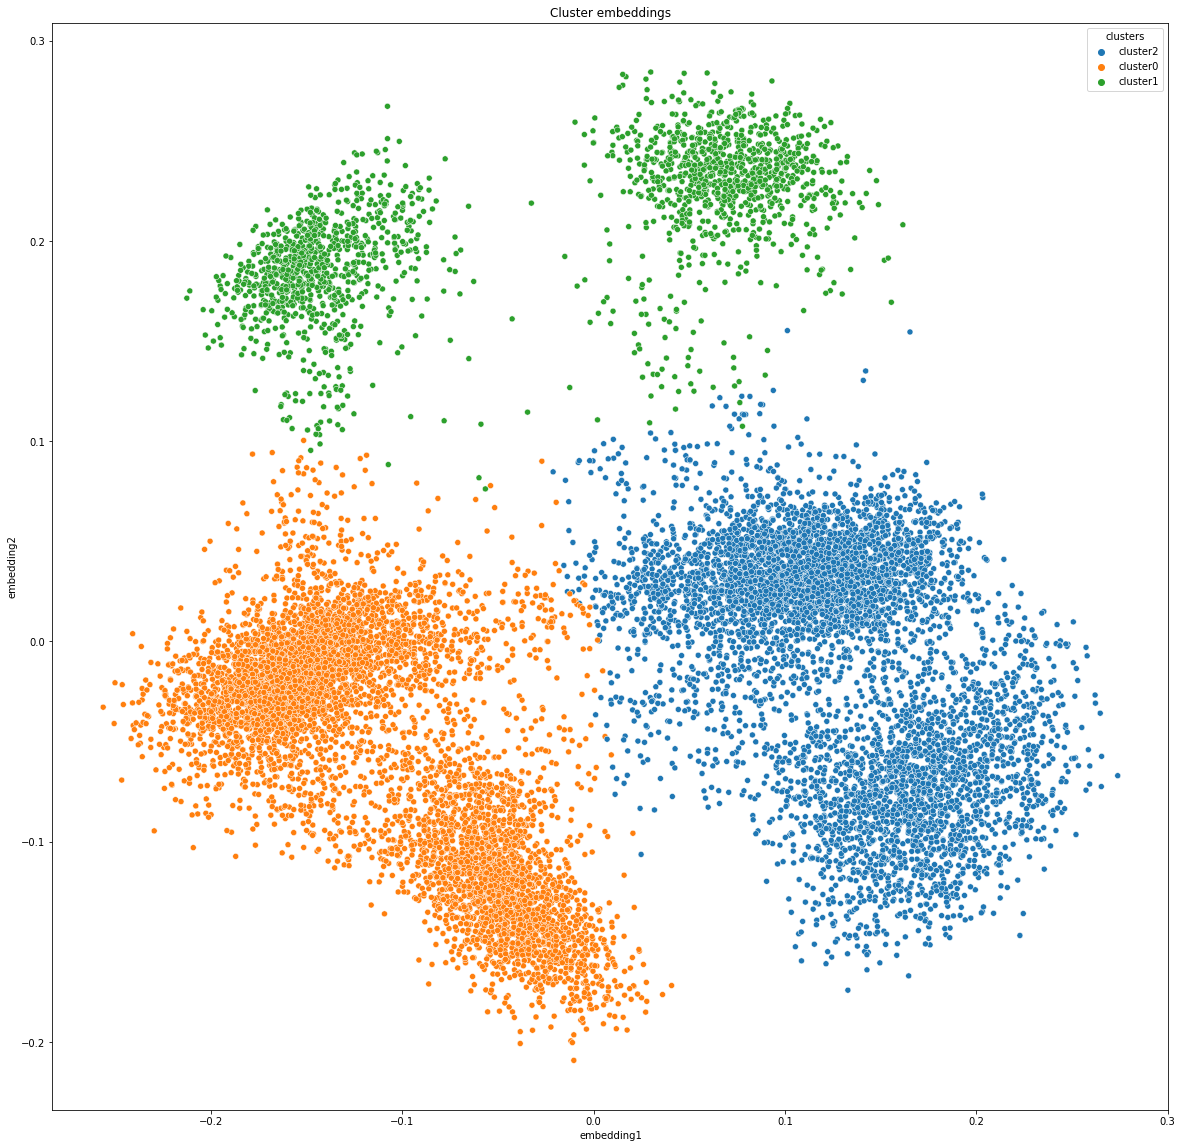

In [72]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Get the embeddings (150 dims) for all the entities of interest
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='entity')

# Perform PCA and reduce the dims to 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

# Create a dataframe to plot the embeddings using scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Print only a few labels, to avoid clutter, using adjust_text
# from adjustText import adjust_text
# texts = []
# for i, point in df.iterrows():
#     # randomly choose a few labels to be printed
#     if np.random.uniform() < 0.003:
#         texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))
        
# adjust_text(texts)
plt.show()

## 8.3 Hypothesis Generation

Other times you may wish to discover **any** potential new facts from an existing knowledge graph. 

With a knowledge graph containing millions of entities the space of possible facts is huge, and evaluating all of them can take a very long time. In order to speed up this task we have implemented a number of sampling strategies. 

The strategies implemented include: 
>    ```entity_frequency```, ```graph_degree```, ```cluster_coefficient```, ```cluster_triangles```, ```cluster_squares```, ```random_uniform```, ```exhaustive```. 

Entities in all strategies excluding ```random_uniform```, ```exhaustive``` are sorted in ascending fashion, on the assumption that frequent or densely connected entities are less likely to have missing true statements.

The general procedure is to generate a set of candidate statements, and then rank them against a set of corruptions using the ```ampligraph.evaluation.evaluate_performance()``` function. 

A sampling weight is calculated for each entity using the specified strategy, and ```max_candidates``` are sampled to produce the candidate triple set. 

Candidates are then evaluated to obtain a rank, and triples that appear in the ```top_n``` ranked statements of evaluation procedure are returned as potentially true statements.
            


In [69]:
from ampligraph.discovery import discover_facts

triples, ranks = discover_facts(dataset.values, 
                                model, 
                                top_n=500, 
                                max_candidates=500, 
                                strategy='cluster_triangles', 
                                target_rel='/people/person/profession', 
                                seed=42)

for triple, rank in zip(triples, ranks):
    print('Rank: {} \t {} '.format(rank, triple))


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 500/500 [00:02<00:00, 190.17it/s]


Rank: 6.0 	 ['bob clampett' '/people/person/profession' 'actor'] 
Rank: 298.5 	 ['bob boyle' '/people/person/profession' 'actor'] 
Rank: 295.0 	 ['thomas newman' '/people/person/profession' 'actor'] 
Rank: 489.5 	 ['bob clampett' '/people/person/profession' 'family plot'] 


---
# 9. Visualizing embeddings using Tensorboard

Tensorboard Projector allows us to visualize high dimensional embeddings in a graphical interface. This can be useful to examine and understand embedded concepts. 

Ampligraph provides a single function for creating the Tensorboard files, [create_tensorboard_visualizations](https://docs.ampligraph.org/en/latest/generated/ampligraph.utils.create_tensorboard_visualizations.html#ampligraph.utils.create_tensorboard_visualizations), as demonstrated below.


In [70]:
from ampligraph.utils import create_tensorboard_visualizations

model = restore_model('TransE.pkl')

create_tensorboard_visualizations(model, 'embeddings_transe')

Run the cell below to run tensorboard, and it will open in a different browser window with the tensorboard interface.

In [71]:
# This will not work in google colab - only uncomment and run if using jupyter notebook 

# ! tensorboard --logdir='./embeddings_transe'

# Appendix


**Assume you are incrementally building knowledge graphs and training models in phases. Can you compare the models trained on these incremental datasets?**

Depends. You should have the same test set and same number of corruptions when you want to compare models. If you are only adding new links incrementally, it does not matter. The models would be comparable. However, if you are also adding new concepts, then you must be careful while evaluating the models. You must make sure that the number of corruptions generated are the same throughout. You can choose a set of entities that would be used as corruptions in all the phases and then use `entities_subset` argument of `evaluate_performance` API.


**What if my embedding matrices are not fitting on the GPU?**

Sometime while running the model, you may run into ResourceExhausted error on the GPU, especially because the batches may not fit in memory. This can usually be solved by increasing the batch count. 

There are times when you may have millions of entities in the graph, and you may not be able to allocate the embedding matrix on the GPU. In this case, you can use the [large graph mode](https://docs.ampligraph.org/en/latest/dev_notes.html#dealing-with-large-graphs). It gets activated automatically when number of entities is >500000. You can also use `set_entity_threshold` and change this threshold manually. 
```
from ampligraph.latent_features import set_entity_threshold
set_entity_threshold(100000)

...
```

In this mode, ampligraph creates the embedding matrix on the CPU and loads only the embeddings of the entities of the batch being trained on the GPU. This mode is much faster than training just on CPU as it can use the GPU cores to speed up computations. More details can be found in the link.
